In [186]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import nengo
import nengo_dl
from tensorflow.keras.utils import to_categorical

#sources:
#https://www.kaggle.com/code/vtu5118/cifar-10-using-vgg16
#https://towardsdatascience.com/creating-vgg-from-scratch-using-tensorflow-a998a5640155

In [2]:
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                    include_top=False,
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

model = tf.keras.models.Sequential()

# Add vgg16 layers
for layer in vgg16_model.layers:
    # Replace max pool with avg pool (nengo doesnt support max pooling)
    if isinstance(layer, tf.keras.layers.MaxPooling2D):
        model.add(tf.keras.layers.AveragePooling2D(layer.pool_size, layer.strides, layer.padding, layer.data_format))
        continue
    model.add(layer)


# Fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', name='hidden1'))
# model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256, activation='relu', name='hidden2'))
# model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='softmax', name='predictions'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 64)       0         
 ooling2D)                                                       
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 average_pooling2d_1 (Averag  (None, 8, 8, 128)        0         
 ePooling2D)                                            

In [216]:
# Load CIFAR10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# One hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [4]:
# Shuffle data before splitting into validation set
p = np.random.default_rng(seed=42).permutation(len(x_train))
print(x_train.shape)
x_train, y_train = x_train[p], y_train[p]
print(x_train.shape)

# 20% validation, 80% training
val_split = 0.2
num_val = int(val_split * len(x_train))

# Split into train, validation, and test sets
x_val = x_train[:num_val]
y_val = y_train[:num_val]
print(x_val.shape)
print(y_val.shape)

x_train = x_train[num_val:]
y_train = y_train[num_val:]
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 10)
(40000, 32, 32, 3)
(40000, 10)


In [5]:
# For saving model weights
checkpoint_path = "training/vgg16-2.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [6]:
# Train model with tf
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
batch_size_tf = 128
epochs = 100

model.compile(
    optimizer=optimizer,
    # optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

# def lr_scheduler(epoch):
#     return 0.001 * (0.5 ** (epoch // 20))

# reduce_lr = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# aug = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=20,
#     zoom_range=0.15,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.15,
#     horizontal_flip=True,
#     fill_mode="nearest")

# model.fit(aug.flow(x_train,y_train, batch_size=batch_size_tf),
#           batch_size=batch_size_tf,
#           epochs=epochs,
#           callbacks=[reduce_lr, cp_callback],
#           validation_data=(x_val, y_val))

In [7]:
model.load_weights(checkpoint_path)

loss, acc = model.evaluate(x_test, y_test)
# 84% acc with tf
print("Test Acc: {:5.2f}%, Test Loss: {:5.2f}".format(100 * acc, loss))

313/313 [==============================] - 3s 5ms/step - loss: 0.4886 - accuracy: 0.8490
Test Acc: 84.90%, Test Loss:  0.49


In [87]:
# Add time dimension to data for SNN
def add_time_dimension(arr):
    return np.reshape(arr, (arr.shape[0], 1, -1))

# Using original non one-hot-encoded labels
x_train_t = add_time_dimension(x_train)
y_train_t = add_time_dimension(np.argmax(y_train, axis=-1))
x_val_t = add_time_dimension(x_val)
y_val_t = add_time_dimension(np.argmax(y_val, axis=-1))
x_test_t = add_time_dimension(x_test)
y_test_t = add_time_dimension(np.argmax(y_test, axis=-1))

In [218]:
sfr = 20

converter = nengo_dl.Converter(
    model,
    swap_activations={
        tf.keras.activations.relu: nengo.SpikingRectifiedLinear()
    },
    scale_firing_rates=sfr,
    synapse=0.01,
    inference_only=True
)

/root/vgg16-snn/.env/lib/python3.8/site-packages/nengo_dl/converter.py:920: UserWarning: Converting sequential model to functional model; use `Converter.model` to refer to the functional model (rather than the original sequential model) when working with the output of the Converter
  warnings.warn(
/root/vgg16-snn/.env/lib/python3.8/site-packages/nengo_dl/converter.py:583: UserWarning: Activation type <function softmax at 0x7fb2c5a6a280> does not have a native Nengo equivalent; falling back to a TensorNode
  warnings.warn(


In [219]:
# Source: https://r-gaurav.github.io/2021/03/07/Spiking-Neural-Nets-for-Image-Classification-in-Nengo-DL.html
# Tile the test images n_steps times.
def get_nengo_compatible_test_data_generator(x, y, batch_size=100, n_steps=30):
  """
  Returns a test data generator of tiled (i.e. repeated) images.

  Args:
    batch_size <int>: Number of data elements in each batch.
    n_steps <int>: Number of timesteps for which the test data has to
                   be repeated.
  """
  num_images = x.shape[0]
  # Flatten the images
  reshaped_x = x.reshape((num_images, 1, -1))
  # Tile/Repeat them for `n_steps` times.
  tiled_x = np.tile(reshaped_x, (1, n_steps, 1))

  for i in range(0, num_images, batch_size):
    yield (tiled_x[i:i+batch_size], y[i:i+batch_size])

In [252]:
converter_model = converter.model
# model_input = list(converter.inputs.keys())[0]
# model_output = list(converter.outputs.keys())[0]

model_input = converter_model.input
model_output = converter_model.output
model_layers = list(converter.layers.keys())
conv1 = model_layers[12][0]
print(conv1)
penltmt_layer = model_layers[-3]

# Get the probes for Input, first Conv, and the Output layers.
input_probe = converter.inputs[model_input] 
output_probe = converter.outputs[model_output] 
# only record from a subset of neurons, to save memory.
sample_neurons = np.linspace(
    0,
    np.prod((32, 32, 64)),
    1000,
    endpoint=False,
    dtype=np.int32,
)

with converter.net:
  nengo_dl.configure_settings(stateful=False, keep_history=False, inference_only=True) # Optimize simulation speed.
  # Probe for the first Conv layer.
  # print(converter.layers)
  # first_conv_probe = nengo.Probe(converter.layers[conv1][sample_neurons], label="First Conv")
  first_conv_probe = nengo.Probe(converter.layers[conv1], label="First Conv")
  # Probe for penultimate dense layer.
  penltmt_dense_probe = nengo.Probe(converter.layers[penltmt_layer], label="Penultimate Dense")

<Reference wrapping <KerasTensor: shape=(None, 4, 4, 512) dtype=float32 (created by layer 'block4_conv2')>>


In [254]:
n_steps = 256 # Number of timesteps

n_test = 128
x_test_slice = x_test_t[:n_test]
y_test_slice = y_test_t[:n_test]

tiled_test_images = np.tile(x_test_slice, (1, n_steps, 1))

with nengo_dl.Simulator(
        converter.net, progress_bar=False
    ) as nengo_sim:
        data = nengo_sim.predict({input_probe: tiled_test_images})

predictions = np.argmax(data[output_probe][:, -1], axis=-1, keepdims=True)
# print(data[output_probe],)
# print(predictions)
# print(y_test_slice)
accuracy = (y_test_slice == predictions).mean()
print(f"Test accuracy: {100 * accuracy:.2f}%")


2024-09-30 04:00:37.987520: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 384.00MiB (rounded to 402653184)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-09-30 04:00:37.989487: W tensorflow/tsl/framework/bfc_allocator.cc:492] ****************************************************************************************************


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [249]:
tf.nn.softmax(data[output_probe][:, -1][0])

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.09497441, 0.09406052, 0.10187288, 0.09875824, 0.11298891,
       0.10240811, 0.09612399, 0.11125935, 0.09412479, 0.09342887],
      dtype=float32)>

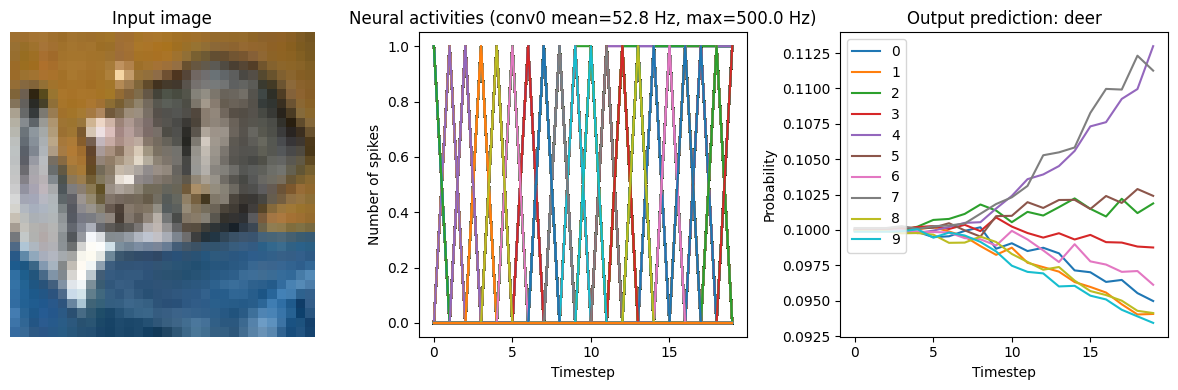

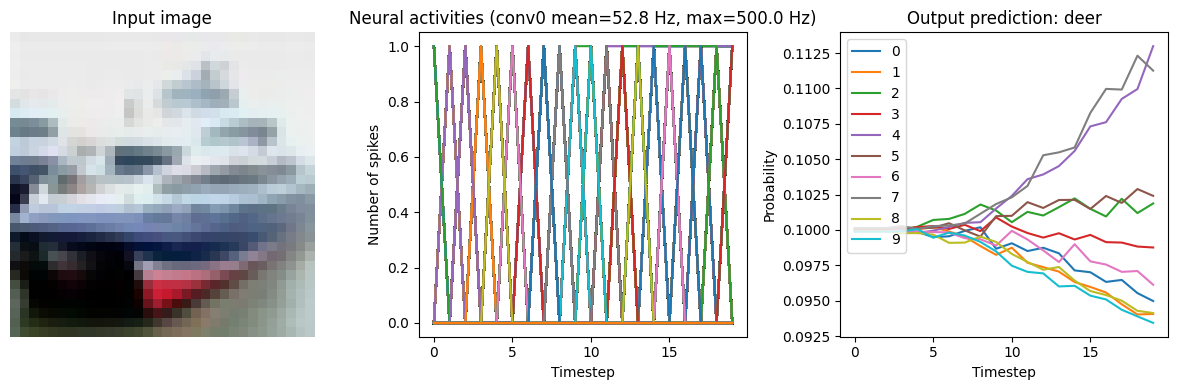

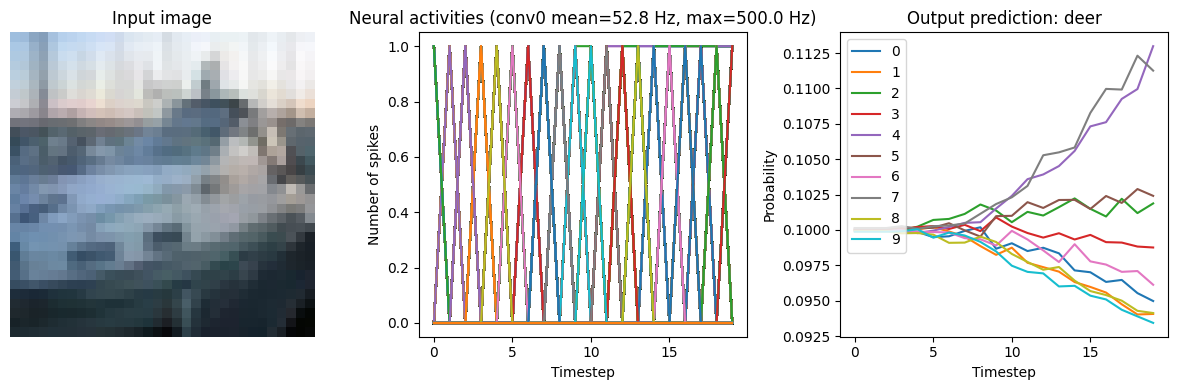

In [250]:
# plot the results
for i in range(3):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Input image")
    plt.imshow(np.reshape(x_test_t[i], (32, 32, 3)))
    plt.axis("off")

    plt.subplot(1, 3, 2)

    scaled_data = data[first_conv_probe][i] * sfr
    scaled_data *= 0.001
    rates = np.sum(scaled_data, axis=0) / (n_steps * nengo_sim.dt)
    plt.ylabel("Number of spikes")
    
    plt.xlabel("Timestep")
    plt.title(
        f"Neural activities (conv0 mean={rates.mean():.1f} Hz, "
        f"max={rates.max():.1f} Hz)"
    )
    plt.plot(scaled_data)
    
    plt.subplot(1, 3, 3)
    plt.title(f"Output prediction: {class_names[predictions[i][0]]}")
    # plt.plot(to_categorical(predictions[i][0], num_classes=10))
    plt.plot(tf.nn.softmax(data[output_probe][i]))
    plt.legend([str(j) for j in range(10)], loc="upper left")
    plt.xlabel("Timestep")
    plt.ylabel("Probability")

    plt.tight_layout()